# How to inject artifical signals into K2 light curves

`lightkurve` will include a method to inject artificial signals (e.g. supernovae, planetary transits, rotation, flares) into K2, Kepler, TESS, and potentially ground based light curves. 

Let's download a K2 light curve of a galaxy. Currently, injection works on the light curve level, so we'll need to construct a light curve from the target pixel file.

In [1]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()              

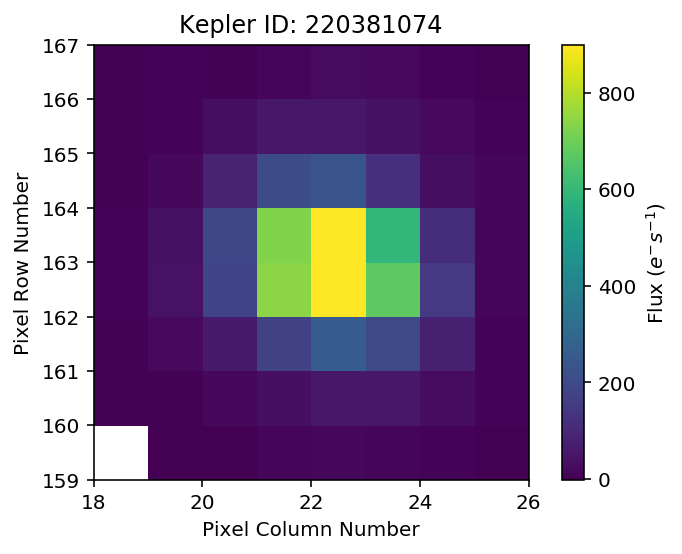

In [2]:
tpf.plot()

(0, 1.5)

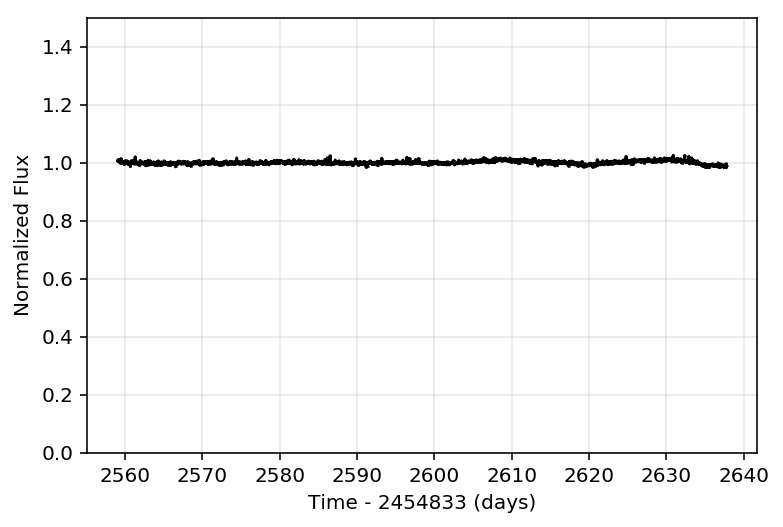

In [3]:
lc.plot();
plt.ylim(0, 1.5)

This light curve of this galaxy is fairly smooth, but there may be some variability from the spacecraft motion and thermal fluctuations.
Now let's inject a supernova with the new `.inject` method. You'll need to install [sncosmo](http://sncosmo.readthedocs.io/) for this method to work.

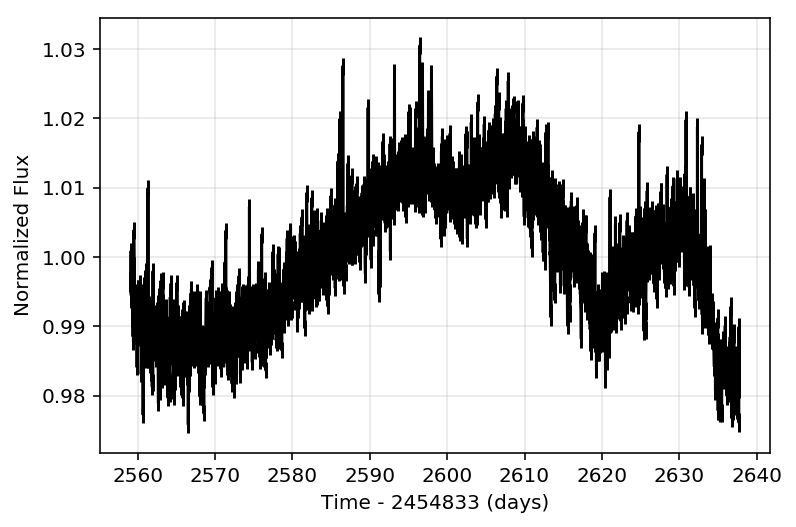

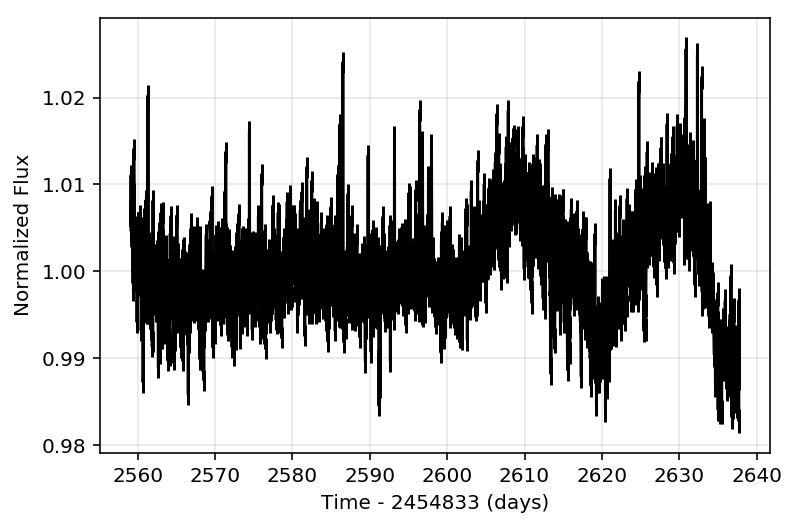

In [6]:
lcinj = lc.inject()

lcinj.plot()
lc.plot()


We injected a supernova light curve into this galaxy